In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
# Load data
users = pd.read_csv('takehome_users.csv', encoding='latin1')
engagement = pd.read_csv("takehome_user_engagement.csv")

In [3]:
# Convert timestamp to datetime
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [4]:
def is_adopted(login_dates):
    login_dates = pd.Series(login_dates).sort_values(ascending=True).reset_index(drop=True)
    for i in range(len(login_dates) - 2):
        if (login_dates[i + 2] - login_dates[i]).days <= 7:
            return True
    return False

# Identify adopted users
adopted_user_ids = []
for user_id, group in engagement.groupby('user_id'):
    login_dates = group['time_stamp'].dt.date
    if is_adopted(login_dates):
        adopted_user_ids.append(user_id)

# Merge adoption info into user data
users['adopted'] = users['object_id'].isin(adopted_user_ids)
users['invited'] = users['invited_by_user_id'].notnull()
users['creation_year'] = users['creation_time'].dt.year
users['org_size'] = users.groupby('org_id')['object_id'].transform('count')
users['org_size_quartile'] = pd.qcut(users['org_size'], 4, labels=False, duplicates='drop')

In [5]:
# Analyze adoption by factors
adoption_by_invitation = users.groupby('invited')['adopted'].mean()
adoption_by_year = users.groupby('creation_year')['adopted'].mean()
adoption_by_org_size = users.groupby(pd.qcut(users['org_size'], 4), observed=False)['adopted'].mean()

# Print results
print("Adoption by invitation:")
print(adoption_by_invitation)
print("\nAdoption by creation year:")
print(adoption_by_year)
print("\nAdoption by organization size quartile:")
print(adoption_by_org_size)

Adoption by invitation:
invited
False    0.127709
True     0.146953
Name: adopted, dtype: float64

Adoption by creation year:
creation_year
2012    0.167322
2013    0.154158
2014    0.088744
Name: adopted, dtype: float64

Adoption by organization size quartile:
org_size
(1.999, 21.0]    0.171544
(21.0, 29.0]     0.149332
(29.0, 55.0]     0.135857
(55.0, 319.0]    0.093195
Name: adopted, dtype: float64


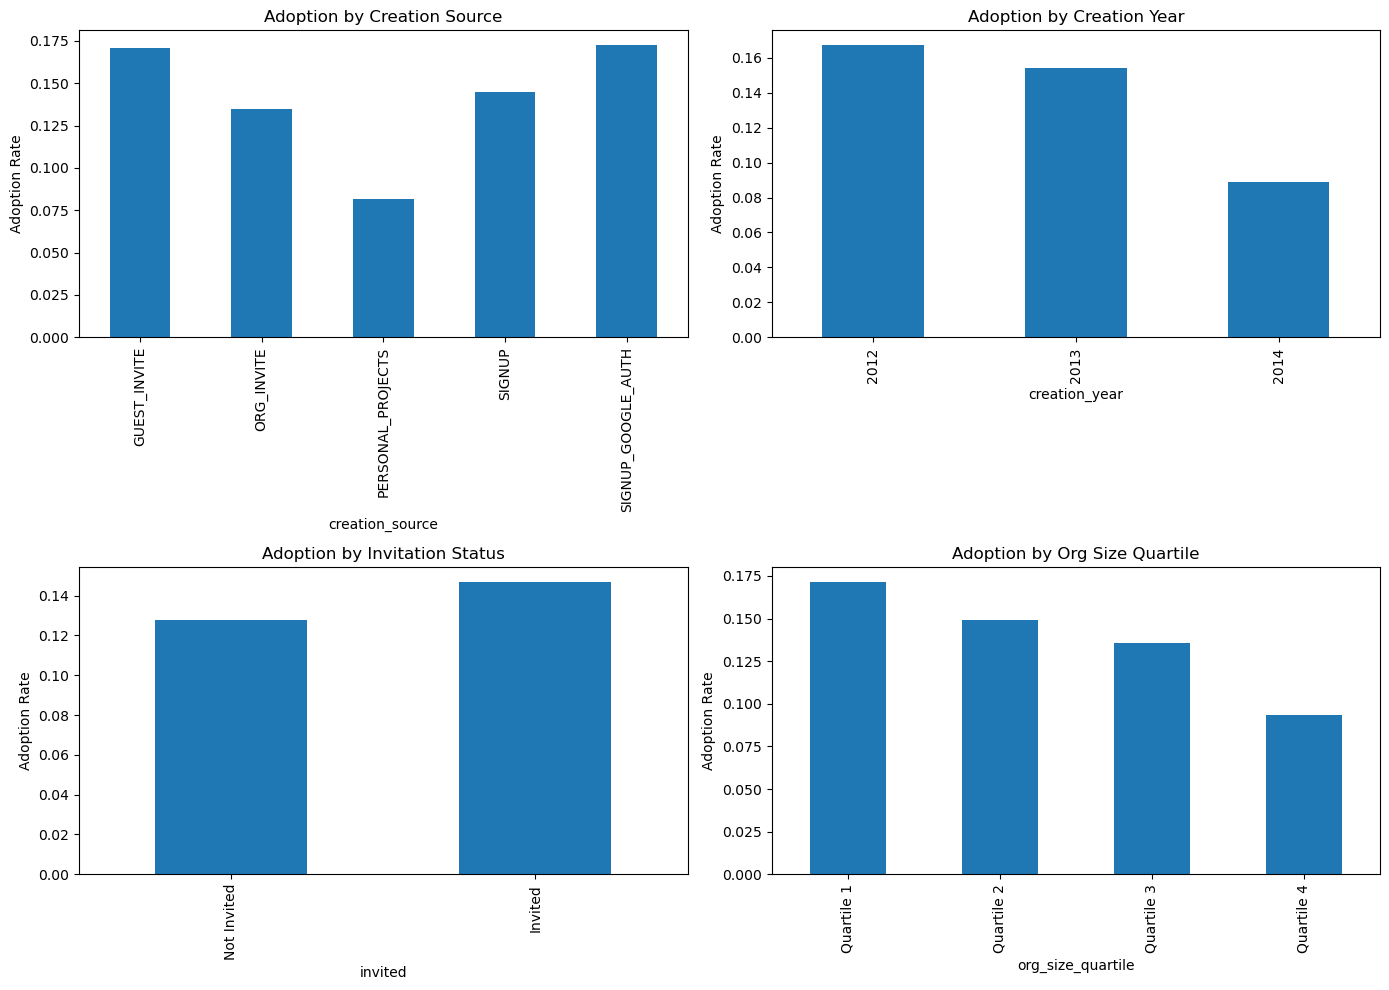

In [13]:
# Plot adoption rates
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Adoption by creation source
source_adoption = users.groupby('creation_source')['adopted'].mean()
source_adoption.plot(kind='bar', ax=axes[0,0], title='Adoption by Creation Source', ylabel='Adoption Rate')

# Adoption by creation year
year_adoption = users.groupby('creation_year')['adopted'].mean()
year_adoption.plot(kind='bar', ax=axes[0,1], title='Adoption by Creation Year', ylabel='Adoption Rate')

# Adoption by invitation status
invited_adoption = users.groupby('invited')['adopted'].mean()
invited_adoption.index = invited_adoption.index.map({True:'Invited', False:'Not Invited'})
invited_adoption.plot(kind='bar', ax=axes[1,0], title='Adoption by Invitation Status', ylabel='Adoption Rate')

# Adoption by organization size quartile
quartile_adoption = users.groupby('org_size_quartile')['adopted'].mean()
quartile_adoption.index = quartile_adoption.index.map(lambda x: f'Quartile {int(x)+1}')
quartile_adoption.plot(kind='bar', ax=axes[1,1], title='Adoption by Org Size Quartile', ylabel='Adoption Rate')

plt.tight_layout()
plt.savefig('adoption_charts.png')
plt.show()
